# Plot Inside vs Outside Hate Words

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import swifter
import scipy
from collections import Counter

# Auxilary
from functools import reduce
from tqdm import tqdm
from glob import glob
import json
import string
import time
import datetime
import os
import sys

# Plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

C:\Users\Matheus\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Matheus\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Matheus\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


## Specify Subreddit

In [2]:
SUBREDDIT = 'WhiteRights'
print(f"Subreddit: {SUBREDDIT}")

Subreddit: WhiteRights


## Load Word Counts

In [3]:
with open(f'{SUBREDDIT}_inside_hate_word_counts.json', 'r') as f_in:
    inside_counts = json.load(f_in)
    
with open(f'{SUBREDDIT}_outside_hate_word_counts.json', 'r') as f_in:
    outside_counts = json.load(f_in)

In [4]:
df_inside = pd.DataFrame(inside_counts, index=['Inside']).sort_index(axis=1)
df_outside = pd.DataFrame(outside_counts, index=['Outside']).sort_index(axis=1)
df = pd.concat([df_inside, df_outside]).sort_index(axis=1)
df.fillna(0, inplace=True)

## Select Top Words

In [5]:
# Calculate the percentage of each word
df_inside.loc['percentage'] = df_inside.loc['Inside']/df_inside.loc['Inside'].sum()
df_outside.loc['percentage'] = df_outside.loc['Outside']/df_outside.loc['Outside'].sum()

# Sort columns by percentage
df_inside.sort_values('percentage', axis=1, ascending=False, inplace=True)
df_outside.sort_values('percentage', axis=1, ascending=False, inplace=True)

# Select top words
top_words = set()
top_words.update(df_inside.columns.tolist()[:5])
top_words.update(df_outside.columns.tolist()[:5])

# Dict to store percentages of top words
top_dict = {}
inside_sum = 0.0
outside_sum = 0.0

# Get the percentages for top words
for word in top_words:
    top_dict[word] = {'Inside': df_inside.at['percentage', word],
                      'Outside': df_outside.at['percentage', word]}
    inside_sum += df_inside.at['percentage', word]
    outside_sum += df_outside.at['percentage', word]

# Add all remaining words as other
top_dict['other'] = {'Inside': 1 - inside_sum,
                     'Outside': 1 - outside_sum}

# DataFrame
df_top = pd.DataFrame(top_dict)

# Sort columns by percentage
df_top.sort_values('Inside', axis=1, ascending=False, inplace=True)
other_col = df_top.pop('other')
df_top.insert(df_top.shape[1], 'other', other_col)

In [6]:
df_top

,jews,niggers,nigger,antiwhite,nazi,nazis,other
Inside,0.539297,0.087156,0.069572,0.066820,0.047248,0.035321,0.154587
Outside,0.464573,0.055671,0.059693,0.028691,0.128609,0.112694,0.150070


## Merge Plural and Singular

#### Inside

In [7]:
# Inside
df_inside_m = df_inside.copy(deep=True)

# Plural s
hate_words = df_inside_m.columns.tolist()
plural_s = [word for word in hate_words if word+'s' in hate_words]
for word in plural_s:
    df_inside_m.at['Inside', word] = df_inside.at['Inside', word] + df_inside.at['Inside', word+'s']
    df_inside_m.drop(columns=word+'s', inplace=True)

# Plural es 
hate_words = df_inside_m.columns.tolist()
plural_es = [word for word in hate_words if word+'es' in hate_words and word not in plural_s]
for word in plural_es:
    df_inside_m.at['Inside', word] = df_inside.at['Inside', word] + df_inside.at['Inside', word+'es']
    df_inside_m.drop(columns=word+'es', inplace=True)
    
# Plural ies
hate_words = df_inside_m.columns.tolist()
plural_ies = [word for word in hate_words if word[:-2]+'ies' in hate_words and word not in plural_s]
for word in plural_ies:
    df_inside_m.at['Inside', word] = df_inside.at['Inside', word] + df_inside.at['Inside', word[:-2]+'ies']
    df_inside_m.drop(columns=word[:-2]+'ies', inplace=True)

# Plural eys
hate_words = df_inside_m.columns.tolist()
plural_eys = [word for word in hate_words if word[:-2]+'eys' in hate_words and word not in plural_s]
for word in plural_eys:
    df_inside_m.at['Inside', word] = df_inside.at['Inside', word] + df_inside.at['Inside', word[:-2]+'eys']
    df_inside_m.drop(columns=word[:-2]+'eys', inplace=True)

#### Outside

In [8]:
# outside
df_outside_m = df_outside.copy(deep=True)

# Plural s
hate_words = df_outside_m.columns.tolist()
plural_s = [word for word in hate_words if word+'s' in hate_words]
for word in plural_s:
    df_outside_m.at['Outside', word] = df_outside.at['Outside', word] + df_outside.at['Outside', word+'s']
    df_outside_m.drop(columns=word+'s', inplace=True)

# Plural es 
hate_words = df_outside_m.columns.tolist()
plural_es = [word for word in hate_words if word+'es' in hate_words and word not in plural_s]
for word in plural_es:
    df_outside_m.at['Outside', word] = df_outside.at['Outside', word] + df_outside.at['Outside', word+'es']
    df_outside_m.drop(columns=word+'es', inplace=True)
    
# Plural ies
hate_words = df_outside_m.columns.tolist()
plural_ies = [word for word in hate_words if word[:-2]+'ies' in hate_words and word not in plural_s]
for word in plural_ies:
    df_outside_m.at['Outside', word] = df_outside.at['Outside', word] + df_outside.at['Outside', word[:-2]+'ies']
    df_outside_m.drop(columns=word[:-2]+'ies', inplace=True)

# Plural eys
hate_words = df_outside_m.columns.tolist()
plural_eys = [word for word in hate_words if word[:-2]+'eys' in hate_words and word not in plural_s]
for word in plural_eys:
    df_outside_m.at['Outside', word] = df_outside.at['Outside', word] + df_outside.at['Outside', word[:-2]+'eys']
    df_outside_m.drop(columns=word[:-2]+'eys', inplace=True)

#### Re-Select Top Words

In [9]:
# Calculate the percentage of each word
df_inside_m.loc['percentage'] = df_inside_m.loc['Inside']/df_inside_m.loc['Inside'].sum()
df_outside_m.loc['percentage'] = df_outside_m.loc['Outside']/df_outside_m.loc['Outside'].sum()

# Sort columns by percentage
df_inside_m.sort_values('percentage', axis=1, ascending=False, inplace=True)
df_outside_m.sort_values('percentage', axis=1, ascending=False, inplace=True)

# Select top words
top_words = set()
top_words.update(df_inside_m.columns.tolist()[:5])
top_words.update(df_outside_m.columns.tolist()[:5])

# Dict to store percentages of top words
top_dict = {}
inside_sum = 0.0
outside_sum = 0.0

# Get the percentages for top words
for word in top_words:
    top_dict[word] = {'Inside': df_inside_m.at['percentage', word],
                      'Outside': df_outside_m.at['percentage', word]}
    inside_sum += df_inside_m.at['percentage', word]
    outside_sum += df_outside_m.at['percentage', word]

# Add all remaining words as other
top_dict['other'] = {'Inside': 1 - inside_sum,
                     'Outside': 1 - outside_sum}

# DataFrame
df_top_m = pd.DataFrame(top_dict)

# Sort columns by percentage
df_top_m.sort_values('Inside', axis=1, ascending=False, inplace=True)
other_col = df_top_m.pop('other')
df_top_m.insert(df_top_m.shape[1], 'other', other_col)

In [10]:
print(sorted(df_outside_m.columns.tolist()))

['antiwhite', 'jews', 'nationalism', 'nationalist', 'nazi', 'negro', 'nigger', 'zionist']


#### Toggle Whether to User Merged Data

In [11]:
df_top = df_top_m.copy(deep=True)

In [12]:
# If there is zero overlap between top 5 inside and outside, with the "other" keyword we'll get 11 words, 
# but max color palette is 10, so drop the word with the lowest combined use
if df_top.shape[1] > 10:
    df_top.drop(columns = ['other'], inplace=True)
    least_frequent_word = df_top.sum(axis='rows').sort_values(ascending=True).keys()[0]
    df_top.drop(columns = [least_frequent_word], inplace=True)
    difference = 1 - df_top.sum(axis='columns') # calculate difference between cumsum and 1.0
    df_top['other'] = difference # allocate the difference value to other

## Customize Colormap

In [13]:
# Customize the tab10 colormap so that gray is always the color for the last word (which is always 'other')
lightblue = plt.cm.tab10.colors[-1]
gray = plt.cm.tab10.colors[-3]
tab10_custom = list(plt.cm.tab10.colors)
tab10_custom[-3] = lightblue
tab10_custom = tab10_custom[:df_top.shape[1]]
tab10_custom[-1] = gray
tab10_custom = tuple(tab10_custom)

In [14]:
# Dict mapping of word to color
word_to_color = {word:clr for word,clr in zip(df_top.columns,tab10_custom)}

# Dict mapping encoded (0-1 scaled) color to actual color name
encoding_to_word = {}
for num, word in enumerate(df_top.columns):
    scaled_num = num/(df_top.shape[1]-1)
    rounded_num = round(scaled_num, 3)
    encoding_to_word[rounded_num] = word

In [15]:
# Take the color encodeding (0-1 scaled), the the word and return its matching color
def get_cmap(encoding):
    rounded_encoding = round(encoding, 3)
    word = encoding_to_word[rounded_encoding]
    color = word_to_color[word]
    return color

## Stacked Bar Chart

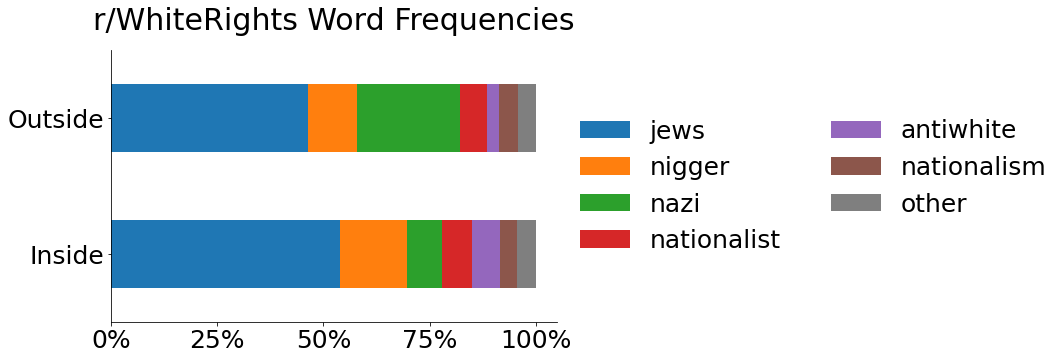

In [16]:
# Horizontal plot
fig, ax = plt.subplots(figsize=(8,5))

# Plot
df_top.plot(kind='barh', stacked=True, ax=ax, legend=False,
            colormap=get_cmap)

# Text
plt.figlegend(loc='upper left', fontsize=25, ncol=2, bbox_to_anchor=(0.9, 0.75), frameon=False)
plt.title(f'r/{SUBREDDIT} Word Frequencies', size=30, pad=20)
ax.tick_params(axis='both', which='major', labelsize=25)

# Set to percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

# Hide axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show
plt.savefig(f"../figures_lexicon/Word_Frequencies_Horizontal_{SUBREDDIT}.png", bbox_inches='tight')
plt.show()

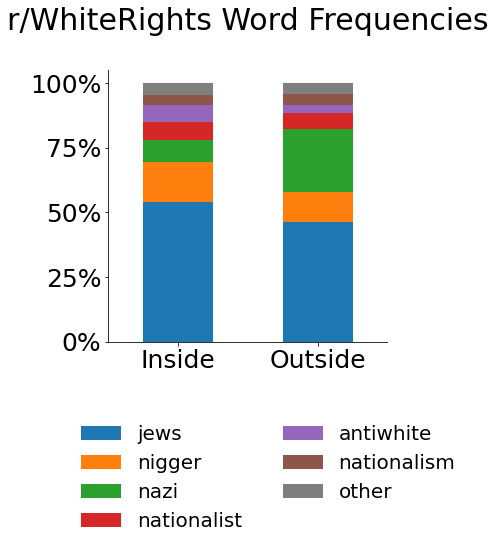

In [17]:
# Vertical plot
fig, ax = plt.subplots(figsize=(5,5))

# Plot
df_top.plot(kind='bar', stacked=True, ax=ax, legend=False,
            colormap=get_cmap)

# Text
plt.figlegend(loc='lower left', fontsize=20, ncol=2, bbox_to_anchor=(0.0, -0.45), frameon=False)
plt.title(f'r/{SUBREDDIT} Word Frequencies', size=30, pad=40)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xticks(rotation=0)

# Set to percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

# Hide axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show
#plt.savefig(f"../figures_lexicon/Word_Frequencies_Vertical_{SUBREDDIT}.png", bbox_inches='tight')
plt.show()

## Pie Chart

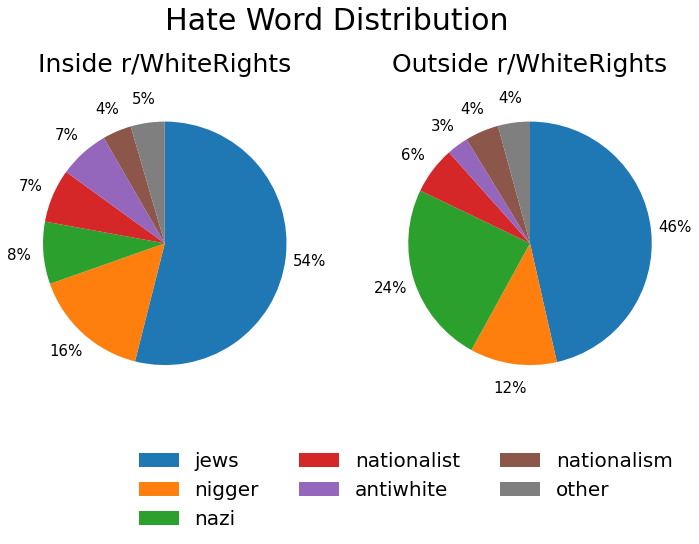

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.suptitle("Hate Word Distribution", size=30, y=1.05)

# colors=list(plt.cm.tab10.colors)
plt.sca(ax[0])
plt.title(f"Inside r/{SUBREDDIT}", size=25, pad=20)
plt.pie(df_top.loc['Inside'], normalize=True, 
        colors=tab10_custom, startangle=90, counterclock=False,  
        autopct=(lambda value: f'{value:.0f}%'), textprops={'fontsize': 15}, pctdistance=1.2)

plt.sca(ax[1])
plt.title(f"Outside r/{SUBREDDIT}", size=25, pad=20)
plt.pie(df_top.loc['Outside'], normalize=True, 
        colors=tab10_custom, startangle=90, counterclock=False, 
        autopct=(lambda value: f'{value:.0f}%'), textprops={'fontsize': 15}, pctdistance=1.2)

plt.figlegend(df_top.columns, loc='lower left', fontsize=20, ncol=3, bbox_to_anchor=(0.25, -0.20), frameon=False)
#plt.savefig(f"../figures_lexicon/Word_Frequencies_Pie_Chart_{SUBREDDIT}.png", bbox_inches='tight')
plt.show()

# End